# 1. 필요한 라이브러리 import

In [1]:
import os
import fnmatch
from collections import Counter
import zipfile
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# 2. 데이터 준비
➡️ 초기 1회만 실행

- 파일 압축 해제

In [2]:
zip_file = zipfile.ZipFile('./resnet1.zip')
zip_file.extractall(path="./data")

- 다른 파일의 압축 해제 및 데이터 병합

In [3]:
# 압축 파일과 대상 디렉토리 경로 설정
zip_file_path = './resnet2.zip'#바꾸기
target_folder_path = './data/resnet1'

# 임시 디렉토리 생성
temp_folder_path = './dd'
os.makedirs(temp_folder_path, exist_ok=True)

# 압축 파일 풀기
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(temp_folder_path)

# 'Video_b3' 폴더 경로 설정
video_folder_path = os.path.join(temp_folder_path, 'resnet2')#바꾸기

# 'Video_b3' 폴더 내부의 파일들을 대상 디렉토리로 복사
for root, _, files in os.walk(video_folder_path):
    for file in files:
        source_file_path = os.path.join(root, file)
        target_file_path = os.path.join(target_folder_path, file)

        # 중복되는 파일이 있을 경우 이름 변경
        if os.path.exists(target_file_path):
            base, extension = os.path.splitext(file)
            counter = 1
            new_file_name = f"{base}_{counter}{extension}"
            new_target_file_path = os.path.join(target_folder_path, new_file_name)
            while os.path.exists(new_target_file_path):
                counter += 1
                new_file_name = f"{base}_{counter}{extension}"
                new_target_file_path = os.path.join(target_folder_path, new_file_name)
            target_file_path = new_target_file_path

        shutil.move(source_file_path, target_file_path)

# 임시 디렉토리 삭제
shutil.rmtree(temp_folder_path)

print("파일 병합이 완료되었습니다.")

파일 병합이 완료되었습니다.


- 손상된 이미지 삭제

In [6]:
folder_path = './data/resnet1'

# 폴더 내의 모든 파일을 순회
for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # 이미지 파일 형식을 여기에 추가
        try:
            img = Image.open(os.path.join(folder_path, filename))  # 이미지 열기 시도
            img.verify()  # 이미지가 손상되었는지 확인
        except (IOError, SyntaxError) as e:
            print(f'{filename} is corrupted and will be deleted.')  # 손상된 이미지 파일명 출력
            os.remove(os.path.join(folder_path, filename))  # 손상된 이미지 삭제


# 3. 데이터의 분포 확인
- go/right/left/stop 별 이미지 데이터의 개수 확인
    - index: 090 ➡️ go
    - index: 135 ➡️ right
    - index: 045 ➡️ left
    - index: 180 ➡️ stop

In [2]:
folder_path = './data/resnet1'

# 이미지 파일 인덱스 집계를 위한 빈 Counter 객체 생성
index_counter = Counter()

# 삭제된 이미지를 제외한 폴더 내의 모든 파일을 순회
for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # 이미지 파일 형식을 여기에 추가
        index = filename[12:15]  # 파일명에서 인덱스 추출
            
        index_counter[index] += 1  # 추출된 인덱스에 대한 카운트 증가

# 인덱스별 이미지 개수 출력
for index, count in index_counter.items():
    print(f'Index: {index}, Count: {count}')

Index: 090, Count: 3308
Index: 135, Count: 3454
Index: 045, Count: 3454


# 4. 데이터를 변수에 저장

image_path: ./data/resnet1\train_00006_090_2.png
steering_Angle: 90


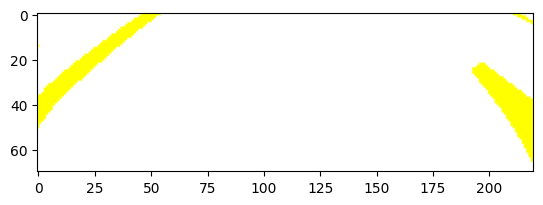

In [3]:
data_dir = './data/resnet1'
file_list = os.listdir(data_dir)
image_paths = [] # 이미지 경로를 저장하는 변수
steering_angles = [] # 이미지 각도를 저장하는 변수
pattern = "*.png" # .png 확장자 가진 파일만 취급

for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        file_path = os.path.join(data_dir, filename)
        try:
            # 이미지 파일을 열어보려고 시도
            with Image.open(file_path) as img:
                # 파일이 성공적으로 열렸다면 리스트에 추가
                image_paths.append(file_path)
                angle = int(filename[12:15]) # 각도는 사진 데이터에서 12~14번째만 분리
                steering_angles.append(angle)
        except:
            # 파일 열기에 실패한 경우, 예외가 발생하고 해당 파일은 무시
            print(f"Failed to open {file_path}")

# 각도가 0인 이미지를 제거
image_paths = [path for path, angle in zip(image_paths, steering_angles) if angle != 0]
steering_angles = [angle for angle in steering_angles if angle != 0]

# 이후 과정은 동일하게 진행
image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index])
print("steering_Angle: %d" % steering_angles[image_index])

df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

# 5. 이미지 전처리 함수 생성

In [4]:
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(70, 220))
    img = img_to_array(img)
    img = img / 255.0  # 정규화하여 [0, 1] 범위로 변환
    return img

# 6. 학습 / 검증 데이터 분리

In [5]:
images = np.array([preprocess_image(path) for path in df['ImagePath']])
angles = np.array(df['Angle'])

X_train, X_val, y_train, y_val = train_test_split(images, angles, test_size=0.2, random_state=42)

# 7. MobileNet 모델 선언

In [7]:
from tensorflow.keras.applications import MobileNet

# MobileNet 모델 선언 및 수정
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(70, 220, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1)(x)
model = Model(inputs=base_model.input, outputs=predictions)

C:\Users\dkgus\AppData\Local\Temp\ipykernel_4380\3078620642.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(70, 220, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


# 8. 학습 및 손실 계산
- 최대 epoch를 30으로 설정, 일정 횟수동안 손실이 일정하다면 조기종료 되도록

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 훈련
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    batch_size=32
)

# 모델 평가
loss = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")

# 모델 저장
model.save('./mobileNet_model.h5')

Epoch 1/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 103s 352ms/step - loss: 780.7336 - val_loss: 836.3284
Epoch 2/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 123s 481ms/step - loss: 140.6572 - val_loss: 356.8580
Epoch 3/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 131s 512ms/step - loss: 123.7374 - val_loss: 169.4687
Epoch 4/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 111s 433ms/step - loss: 97.2472 - val_loss: 154.8854
Epoch 5/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 133s 521ms/step - loss: 89.9483 - val_loss: 119.6921
Epoch 6/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 145s 564ms/step - loss: 99.1036 - val_loss: 103.7017
Epoch 7/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 121s 471ms/step - loss: 64.9096 - val_loss: 98.9598
Epoch 8/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 160s 625ms/step - loss: 59.4851 - val_loss: 75.7340
Epoch 9/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 111s 431ms/step - loss: 56.8739 - val_loss: 68.4255
Epoch 10/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 150s 586ms/step - loss: 56.8131 - val_loss: 213.0260
Epoch 11/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 161s 629ms/step - loss: 43.3

Validation Loss: 50.799739837646484


# 9. 손실 시각화

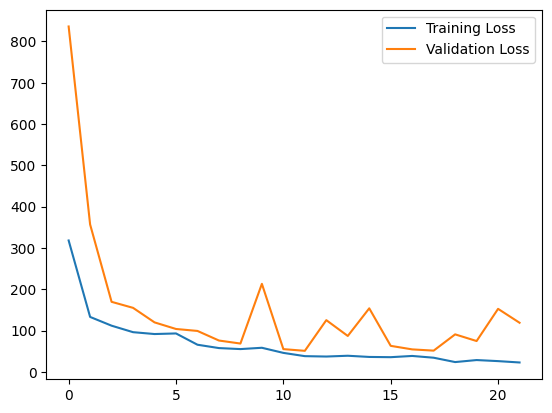

In [9]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# 10. 데이터 예측 시각화

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


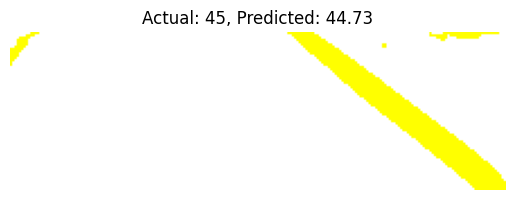

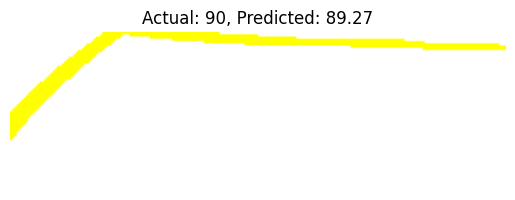

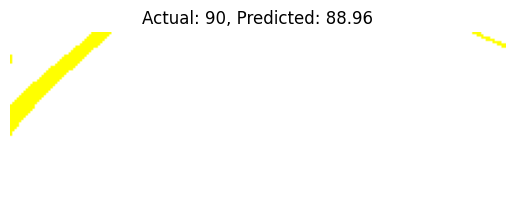

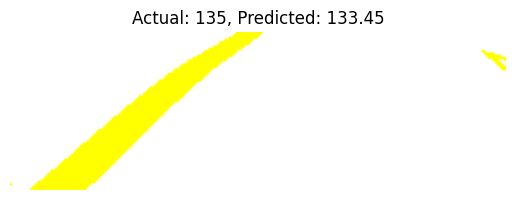

In [10]:
# 모델 로드
model = tf.keras.models.load_model('./mobileNet_model.h5')

# 예시 이미지 4개에 대한 실제 값과 예측값 보여주기
example_indices = np.random.choice(len(df), 4, replace=False)
example_images = [preprocess_image(df['ImagePath'].iloc[idx]) for idx in example_indices]
example_images_array = np.array(example_images)
example_angles = df['Angle'].iloc[example_indices].values

# 예측 수행
predicted_angles = model.predict(example_images_array)

# 실제 값과 예측값 출력
for i in range(4):
    plt.figure()
    plt.imshow(load_img(df['ImagePath'].iloc[example_indices[i]], target_size=(70, 220)))
    plt.title(f"Actual: {example_angles[i]}, Predicted: {predicted_angles[i][0]:.2f}")
    plt.axis('off')
    plt.show()